In [111]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
import os
import importlib

from scipy.signal import butter, filtfilt

import data_processing as d
import lstm_model as m
import extract_gaze_from_video as e
# import visualize_robot_pov_plotly as v

importlib.reload(e)
importlib.reload(d)
importlib.reload(m)
# importlib.reload(v)

video_path = "./videos/c1.avi"
# video_path = "./videos/c8.avi" # wave

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.9.1+cu130
13.0
91200


In [4]:
# extract face direction and yolo poses
yolo_full = d.load_yolo(video_path)
angles, draw_out = e.get_gaze_angles(video_path=video_path)


WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1035) c:\Users\Tian_\Documents\School\Meng\AER 1515\Project\lstm_pipeline\videos\c1.avi: 480x640 2 persons, 32.9ms
video 1/1 (frame 2/1035) c:\Users\Tian_\Documents\School\Meng\AER 1515\Project\lstm_pipeline\videos\c1.avi: 480x640 2 persons, 32.3ms
video 1/1 (frame 3/1035) c:\Users\Tian_\Documents\School\Meng\AER 1515\Project\lstm_pipeline\videos\c1.avi: 480x640 2 persons, 30.1ms
video 1/1 (frame 4/1035) c:\Users\Tian_\Documents\School\

KeyboardInterrupt: 

In [101]:
# returns a list of extracted trajectories. We can treat each item in the list as belonging to a different person
yolo_results_list, yolo_boxes_list, yolo_start_frames = d.match_trajectories_yolo(yolo_full)
gaze_list = d.match_trajectories_facemesh(yolo_boxes_list, yolo_start_frames, draw_out)

In [15]:
# Design filter
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply filter
def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data)  # zero-phase filtering
    return y

# eyeballed based on formula (w/2)/tan(fov/2) camera focal length from fov and sensor size
k = np.array([
    [ 200, 0, 160],
    [0, -200, 200],
    [0, 0, 1]
    ])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"testing on {device}")

# model inference time
model_dir = "./models"
model_path = os.path.join(model_dir, "model.pth")

model = m.SimpleLSTM(input_size = 34).to(device)
if device == 'cpu' or True:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load(model_path))

model.eval()

pred_out_list = []
indices_list = []

seq_len = 25
for yolo_results in yolo_results_list:
    # process yolo output into format compatible with model
    yolo_proc_out, indices = d.process_yolo_output(yolo_results, k, input_freq = 20)
    indices = indices[0]
    vid_len = yolo_proc_out[0].shape[1]

    if vid_len < seq_len: # skip if too short
        pred_out_list += [None]
        indices_list += [None]
        continue

    X, y = d.create_sequences(yolo_proc_out, seq_len, 1)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    print(yolo_proc_out[0].shape)
    print(f"input size with batch: {X_tensor.shape}")

    pred = model(X_tensor)
    pred = pred.cpu().detach().numpy().flatten()

    # Example usage
    fs = 5          # sample rate, Hz
    cutoff = 0.5        # desired cutoff frequency, Hz
    # pred = lowpass_filter(pred, cutoff, fs)

    pred_rescaled = []
    idx_tracker = 0

    print(len(yolo_results))
    pred = np.concatenate((np.zeros(seq_len) - 1, pred))
    # stretch the predictions back out according to indices array
    for i in range(0, len(yolo_results)):
        pred_rescaled += [pred[idx_tracker]]
        if idx_tracker+1 < len(indices) and i+2 > indices[idx_tracker+1]:
            idx_tracker += 1

    pred_rescaled = np.array(pred_rescaled)
    pred_out_list += [pred_rescaled]
    indices_list += [indices]

    # %matplotlib inline
    # plt.plot(range(0, len(pred_rescaled)), pred_rescaled)
    # plt.show()

print(len(pred_out_list))

testing on cuda
(34, 30)
input size with batch: torch.Size([5, 25, 34])
120
(34, 75)
input size with batch: torch.Size([50, 25, 34])
298
(34, 161)
input size with batch: torch.Size([136, 25, 34])
641
(34, 100)
input size with batch: torch.Size([75, 25, 34])
397
(34, 30)
input size with batch: torch.Size([5, 25, 34])
118
14


In [133]:
%matplotlib notebook
# ani = d.plot_validate(X[np.random.randint(len(X))])
ani = d.plot_validate(X[50])
display(HTML(ani.to_jshtml()))

<IPython.core.display.Javascript object>

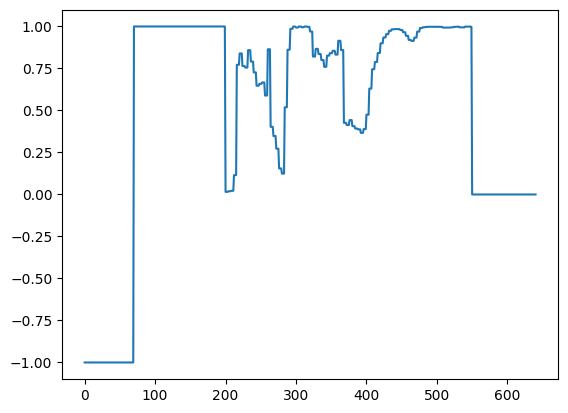

In [27]:
pred_out_list_tweaked = pred_out_list.copy()
pred_out_list_tweaked[0][pred_out_list_tweaked[0] > 0.5] = 0
pred_out_list_tweaked[4][70:200] = 1
pred_out_list_tweaked[4][550:] = 0

plt.plot(range(0, len(pred_out_list_tweaked[4])), pred_out_list_tweaked[4])

In [ ]:
# animations
# ani = d.draw_points_matplot(yolo_proc_out, use_array q= True, only_2d = True)
# display(HTML(ani.to_jshtml()))
d.draw_features(video_path, yolo_results_list, yolo_start_frames, gaze_list = gaze_list,
                 yolo_boxes_list = yolo_boxes_list, pred_results_list = pred_out_list_tweaked, 
                fps_target = 50, start_frame = 240)

KeyboardInterrupt: 